<a href="https://colab.research.google.com/github/theSC0RP/PyTorch-Deep-Learning/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchvision import datasets, models, transforms

In [0]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

trainset = datasets.ImageFolder('natural_images/train', transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, 50, True)

testset = datasets.ImageFolder('natural_images/test', transform = transform)
testloader = torch.utils.data.DataLoader(testset, 50, True)

In [81]:
len(trainset.imgs)

4000

In [82]:
len(testset.imgs)

1600

In [0]:
images, labels = next(iter(trainloader))

In [84]:
images.shape

torch.Size([50, 3, 224, 224])

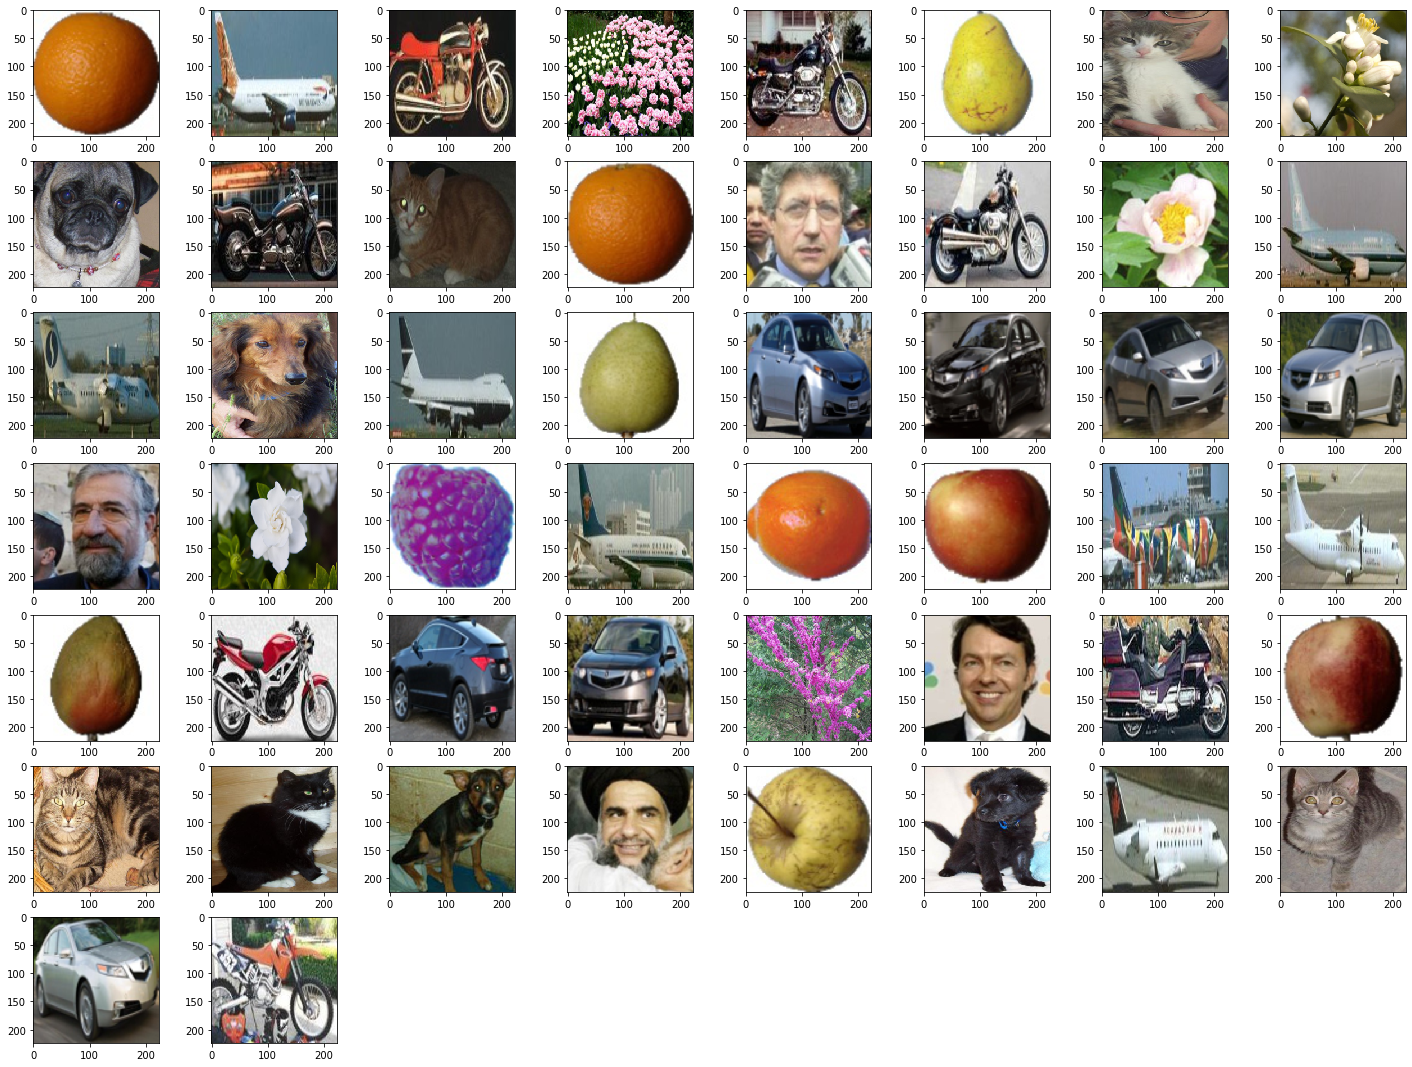

In [85]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 19))
for i in range(50):
  plt.subplot(7, 8, i+1)
  plt.imshow(images[i].permute(1, 2, 0))

In [0]:
model = models.vgg19(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

In [114]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [0]:
# Extracting the fully connected layers from the network

classifier = list(model.classifier.children())

In [0]:
# Tweaking the Linear Layers

from torch import nn
from torch.nn import Linear, ReLU, Dropout

log_softmax = torch.nn.LogSoftmax(dim = 1)

classifier[3] = Linear(4096, 2048)
classifier[6] = Linear(2048, 1024)
additional_layers = [ReLU(True), Dropout(), Linear(1024, 8)]

classifier = classifier + additional_layers

In [0]:
# Changing the fully connected layers in the network

model.classifier = torch.nn.Sequential(*classifier) # '*' is used to unpack the list

In [118]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=2048, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=2048, out_features=1024, bias=True)
  (7): ReLU(inplace=True)
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=1024, out_features=8, bias=True)
)

In [0]:
# Moving model to GPU

model = model.to('cuda')
model = nn.DataParallel(model)

In [120]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

133,285,960 total parameters.
10,497,032 training parameters.


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 0.003)
num_epochs = 10

In [122]:
for e in range(num_epochs):
  running_loss = 0
  correct = 0
  for images, labels in trainloader:
    images = images.to('cuda')
    labels = labels.to('cuda')

    # Forward Pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    (max_vals, arg_maxs) = torch.max(outputs.data, dim=1)
    correct += torch.sum(labels == arg_maxs)

    # Backpropogation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss
  print("{}/{} ---> loss: {:.3f} accuracy: {:.2f}%".format(e+1, num_epochs, running_loss, correct / 40.0))

1/10 ---> loss: 156.98963928222656 accuracy: 31%
2/10 ---> loss: 132.0528564453125 accuracy: 71%
3/10 ---> loss: 95.70331573486328 accuracy: 90%
4/10 ---> loss: 59.34490966796875 accuracy: 94%
5/10 ---> loss: 36.0904655456543 accuracy: 96%
6/10 ---> loss: 24.516366958618164 accuracy: 96%
7/10 ---> loss: 18.225950241088867 accuracy: 97%
8/10 ---> loss: 14.573729515075684 accuracy: 97%
9/10 ---> loss: 12.190728187561035 accuracy: 97%
10/10 ---> loss: 10.866424560546875 accuracy: 97%


In [124]:
with torch.no_grad():
  correct = 0
  for images, labels in testloader:
    images = images.to('cuda')
    labels = labels.to('cuda')
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    (max_vals, arg_maxs) = torch.max(outputs.data, dim = 1)
    correct += torch.sum(arg_maxs == labels)
  print("Accuracy: {:.2f} %".format(correct / 16))

Accuracy: 97.00 %
